# Project: 인물 모드 문제점 찾기
- Semantic Segmentation

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

## 1. 배경 적용

In [2]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드 시작
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f14411676a0>)

In [3]:
# 진행되는 과정을 모듈화 해서 적용해본다
class BackgroundChanger:
    def __init__(self, model_file):
        self.model = semantic_segmentation()
        self.model.load_pascalvoc_model(model_file) # load model
    
    def segmentation(self, img_path, background_path=None, class_id=15): # 우선 person을 default로 둔다 (dog: 12)
        self.img_orig = cv2.imread(img_path) # 이미지 불러오기
            
        segvalues, output = self.model.segmentAsPascalvoc(img_path) # segmentation 진행
        seg_color = set_colormap(class_id) # color map 가져오기
        self.seg_map = np.all(output==seg_color, axis=-1)

        img_show = self.img_orig.copy()
        img_mask = self.seg_map.astype(np.uint8) * 255
        color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
        img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
        
        if background_path is not None: # background path를 지정한 경우 배경 이미지와 합성
            background_img = cv2.imread(background_path)
            background_img = cv2.resize(background_img, self.img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
        else: # background path를 지정하지 않으면 blur 처리를 진행
            background_img = cv2.blur(self.img_orig, (22,22)) # 값이 커질수록 blur 정도가 커진다
            
        img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
        img_bg_mask = cv2.bitwise_not(img_mask_color)
        self.img_bg = cv2.bitwise_and(background_img, img_bg_mask)
        self.img_concat = np.where(img_mask_color==255, self.img_orig, self.img_bg) # 배경과 segment와 합쳐주기
    
    def plot_process(self): # 합성되는 step 일부 출력
        plt.figure(figsize=(10, 15))
        for i, img in enumerate([self.img_orig, self.seg_map, self.img_bg, self.img_concat]):
            ax = plt.subplot(1, 4, i+1)
            plt.axis("off")
            try:
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            except Exception:
                plt.imshow(img, cmap="gray")
        
        
    def plot_output(self): # 합성 결과만 출력
        plt.figure(figsize=(7, 7))
        plt.axis("off")
        plt.imshow(cv2.cvtColor(self.img_concat, cv2.COLOR_BGR2RGB))
        plt.show()
        
def set_colormap(class_id):
    #컬러맵 만들기 
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
        
    return colormap[class_id][::-1]

In [4]:
# 이미지 경로 지정
person_img_path = "./images/selfie.jpg"
animal_img_path = "./images/happydog.jpg"
background_img_path = "./images/background.jpg"

In [5]:
snow = BackgroundChanger(model_file) # init

### 1) person

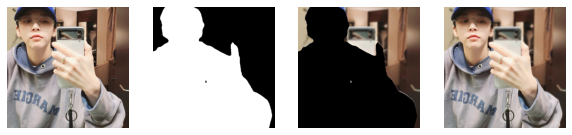

In [6]:
snow.segmentation(person_img_path)
snow.plot_process()

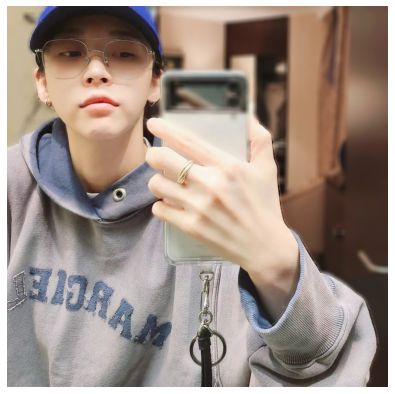

In [7]:
snow.plot_output()

### 2) animal

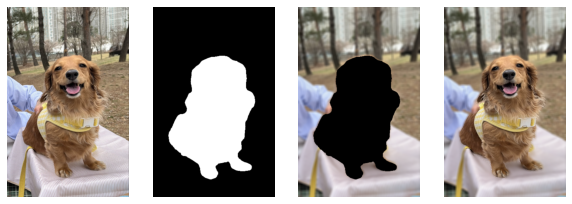

In [8]:
snow.segmentation(animal_img_path, class_id=12)
snow.plot_process()

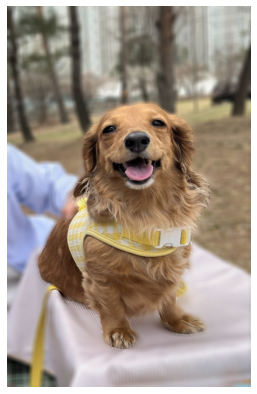

In [9]:
snow.plot_output()

### 3) background

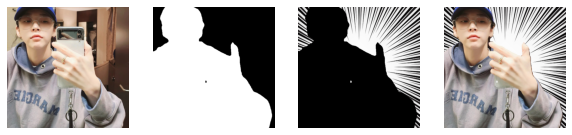

In [10]:
snow.segmentation(person_img_path, background_path=background_img_path)
snow.plot_process()

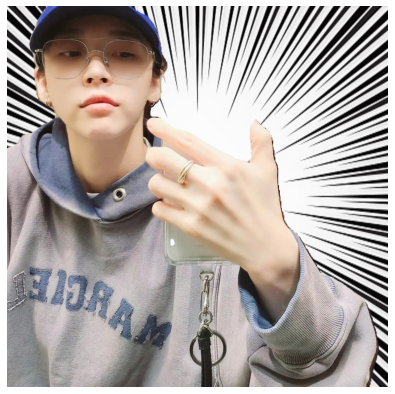

In [11]:
snow.plot_output()

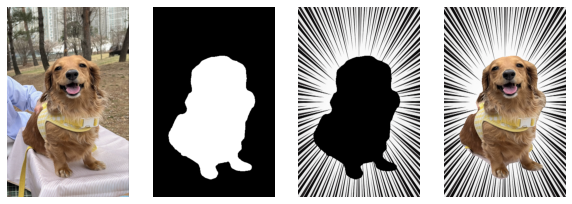

In [12]:
snow.segmentation(animal_img_path, background_path=background_img_path, class_id=12)
snow.plot_process()

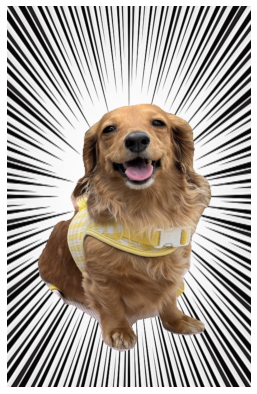

In [13]:
snow.plot_output()

## 2. 문제점

1. segmentation 된 object 주변에 테두리가 남아 있다.
2. segmentation 하고자 하는 object와 겹치는 다른 object는 구분하지 못한다. (person 사진에서 보면 휴대폰 윗부분은 완벽히 제외가 되었지만, 사람 몸통 부분에 있는 아랫부분은 제외가 되지 않았다.)
3. segmentation이 완벽히 되지 않고, 일부 배경이 같이 segmentation 되었다.

## 3. 해결 방법

1. object 주변에 남아있는 테두리는 검정색일 것이다. 이미지를 합친 후 작게 패치를 나눠서 주변 background나 segment 부분의 색을 가져오는 방향으로 수정해줄 수 있을 것 같다는 생각이 들었다.
2. 오늘 사용한 모델의 class에 휴대폰이 없어서 구분하지 못했을 수도 있을 것 같다. 좀 더 세분화된 class를 가진 데이터로 학습한 모델을 사용하면 해결할 수 있을 것 같다.
3. 1번과 비슷한 방법으로, segment 부분에서 패치를 나눠서 주변 색과 다른 부분은 검정색으로 바꿔주고, 1번의 작업을 진행하면 될 것 같다.

아직 이미지 처리에 대한 지식이 부족해서 생각한 해결 방법이 실제로 해법이 될 수 있을지는 모르겠지만, 한 번 쯤 시도해봐도 좋을 것 같다는 생각이 들었다.